In [1]:
import os
import urllib
from pathlib import Path

import awkward as ak
import dask
import dask_awkward as dak
import numpy as np
import hist.dask

import warnings
warnings.filterwarnings("ignore")

from coffea.nanoevents import NanoEventsFactory, PHYSLITESchema
from coffea import dataset_tools


/usr/local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
def filter_name(name):
    return name in [
        "AnalysisElectronsAuxDyn.pt",
        "AnalysisElectronsAuxDyn.eta",
        "AnalysisElectronsAuxDyn.phi",
        "AnalysisElectronsAuxDyn.m",
        
        "AnalysisMuonsAuxDyn.pt",
        "AnalysisMuonsAuxDyn.eta",
        "AnalysisMuonsAuxDyn.phi",
        "AnalysisMuonsAuxDyn.m",
        
        "AnalysisJetsAuxDyn.pt",
        "AnalysisJetsAuxDyn.eta",
        "AnalysisJetsAuxDyn.phi",
        "AnalysisJetsAuxDyn.m",
        
        "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb",
        "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pc",
        "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pu",
        
        "EventInfoAuxDyn.mcEventWeights"
    ]

In [3]:
mc_file = "https://cernbox.cern.ch/remote.php/dav/public-files/BPIO76iUaeYuhaF/DAOD_PHYSLITE.37233417._000052.pool.root.1"

# download for subsequent use
local_file_name = "ttbar.root"

if not os.path.exists(local_file_name):
    urllib.request.urlretrieve(mc_file, filename=local_file_name)

events = NanoEventsFactory.from_root(
    {mc_file: "CollectionTree"},
    schemaclass=PHYSLITESchema,
    delayed=True,
    uproot_options=dict(filter_name=filter_name),
).events()

### B-tagging discriminant

The DL1 b-tagging flavour tagging algorithm is used for pre-analysis of data stored in PHYSLITE format and used in this analysis. The output of the DL1 algorithm is the $p_b$ $p_c$ and $p_u$ variables that are combined by the following formula to define the final discriminant on b-tagging

$$
D_{DL1} = log \left( \frac{p_b}{f_c \cdot p_c + (1-f_c) \cdot p_u} \right)
$$ 

The $p_b$ $p_c$ and $p_u$ are stored in the file under field names `BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb`, `BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb` and `BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pu` respectively. For more information about discriminant value please refer to the following [link](https://ftag.docs.cern.ch/recommendations/algs/2019-recommendations/#algorithm-structure) (Please note that the CERN account might be needed).

$f_c$ is the constant which equal to $f_c = 0.018$ in this analysis.

In [4]:
def calculate_jets_btagDL1d(events):
    
    BTagging = events.BTagging_AntiKt4EMPFlow
    
    f_c = 0.018
    DDL1 = BTagging.DL1dv01_pb/(f_c*BTagging.DL1dv01_pc + (1-f_c)*BTagging.DL1dv01_pu)

    DDL1 = np.log(DDL1)

    return DDL1

In [5]:
def calculate_trijet_mass_and_ev_filter(events):
    # pT > 30 GeV for leptons, > 25 GeV for jets
    selected_electrons = events.Electrons[events.Electrons.pt > 30 & (np.abs(events.Electrons.eta) < 2.1)]
    selected_muons = events.Muons[events.Muons.pt > 30 & (np.abs(events.Muons.eta) < 2.1)]
    
    # calculate tagging variable and attach it to jets
    jets = events.Jets
    jets["btagDL1d"] = calculate_jets_btagDL1d(events)
    selected_jets = jets[events.Jets.pt > 25 & (np.abs(events.Jets.eta) < 2.4)] 
    
    # single lepton requirement
    event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
    # at least four jets
    event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
    # at least two b-tagged jets ("tag" means score above threshold)
    B_TAG_THRESHOLD = 2.456
    event_filters = event_filters & (ak.sum(selected_jets.btagDL1d > B_TAG_THRESHOLD, axis=1) >= 2)
    
    # apply filters
    selected_jets = selected_jets[event_filters]
    
    trijet = ak.combinations(selected_jets, 3, fields=["j1", "j2", "j3"])  # trijet candidate
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # four-momentum of tri-jet system

    trijet["max_btag"] = np.maximum(trijet.j1.btagDL1d, np.maximum(trijet.j2.btagDL1d, trijet.j3.btagDL1d))
    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
        
    # pick trijet candidate with largest pT and calculate mass of system
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    
    
    return ak.flatten(trijet_mass), event_filters

In [6]:
reconstructed_top_mass, _ = calculate_trijet_mass_and_ev_filter(events)
hist_reco_mtop = hist.dask.Hist.new.Reg(16, 0, 375, label="$m_{bjj} [GeV]$").Double().fill(reconstructed_top_mass/1000)

(0.0, 375.0)

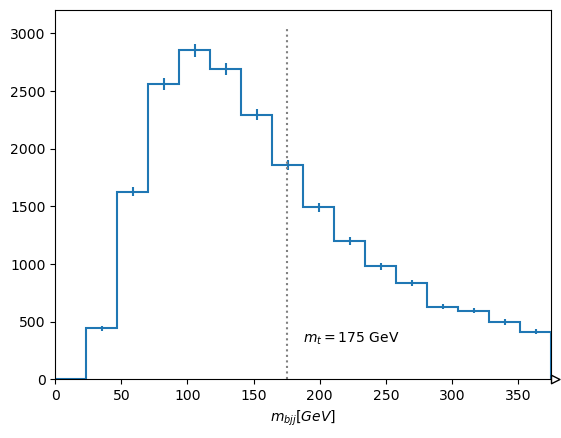

In [7]:
# perform computation and visualize
artists = hist_reco_mtop.compute().plot()

# and annotate the visualization
fig_dir = Path.cwd() / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

ax = artists[0].stairs.axes
fig = ax.get_figure()
ax.vlines(175, 0, ax.get_ylim()[1], colors=["grey"], linestyle="dotted") 
ax.text(0.5, 0.1, "$m_{t} = 175$ GeV", transform = ax.transAxes)
ax.set_xlim([0, 375])
# ax.set_ylim([0, None])

## Now do the same thing with scaling for multiple files which are processed in parallel

In [8]:
from dask.distributed import Client

# Set up the client distribution calculation for coffea-opendata.casa. Change the URL for UChicago
client = Client("tls://localhost:8786")

# TODO: Calculate the sum of weight manually instead of taking it from the file, it make the code to be much more flexible concerning the input files.

In [9]:
import file_utils

LUMINOSITY = 36100 

fileset = {
"singletop_schan_lept_top"  : 
            {
            'files': {name:'CollectionTree' for name in file_utils.filenames_singletop_schan_lept_top},
            'metadata': {"cross-section": 2.027, 
                         "filter-efficiency": 1.0, 
                         "k-factor": 1.017, 
                         "sum-of-weights":365019.0806794167, 
                         "process-label":"singletop_schan_lept"},
            },
"singletop_schan_lept_antitop":
            {
            'files': {name:'CollectionTree' for name in file_utils.filenames_singletop_schan_lept_antitop},
            'metadata': {"cross-section": 1.2674, 
                         "filter-efficiency": 1.0, 
                         "k-factor": 1.0167, 
                         "sum-of-weights":152312.88860154152, 
                         "process-label":"singletop_schan_lept"},
            },
"tchan_BW50_lept_top":
            {
            'files': {name:'CollectionTree' for name in file_utils.filenames_tchan_BW50_lept_top},
            'metadata': {"cross-section": 36.996, 
                         "filter-efficiency": 1.0, 
                         "k-factor": 1.1935, 
                         "sum-of-weights":124412662.10998064, 
                         "process-label":"tchan_BW50_lept"},
            },
"tchan_BW50_lept_antitop":
            {
            'files': {name:'CollectionTree' for name in file_utils.filenames_tchan_BW50_lept_antitop},
            'metadata': {"cross-section": 22.173, 
                         "filter-efficiency": 1.0, 
                         "k-factor": 1.1849, 
                         "sum-of-weights":44399910.88976225, 
                         "process-label":"tchan_BW50_lept"},
            },
"tW_dyn_DR_incl_antitop":
            {
            'files': {name:'CollectionTree' for name in file_utils.filenames_tW_dyn_DR_incl_antitop},
            'metadata': {"cross-section": 35.972, 
                         "filter-efficiency": 1.0, 
                         "k-factor": 1.0, 
                         "sum-of-weights":96216887.40345384, 
                         "process-label":"tW_dyn_DR_incl"},
            },
"tW_dyn_DR_incl_top":
            {
            'files': {name:'CollectionTree' for name in file_utils.filenames_tW_dyn_DR_incl_top},
            'metadata': {"cross-section": 36.003, 
                         "filter-efficiency": 1.0, 
                         "k-factor": 1.0, 
                         "sum-of-weights":95054189.43354416, 
                         "process-label":"tW_dyn_DR_incl"},
            },
"ttbar_hdamp258p75_nonallhad":
            {
            'files': {name:'CollectionTree' for name in file_utils.filenames_ttbar_hdamp258p75_nonallhad},
            'metadata': {"cross-section": 729.77, 
                         "filter-efficiency": 0.5437965, 
                         "k-factor": 1.139756362, 
                         "sum-of-weights": 24014984445.81677, 
                         "process-label":"ttbar_hdamp258p75_nonallhad"},
            }
}      
    
samples, _ = dataset_tools.preprocess(fileset)

In [10]:
def create_histogram(events):

    reconstructed_top_mass, event_filters = calculate_trijet_mass_and_ev_filter(events)
        
    cross_section = events.metadata["cross-section"]
    filter_efficiency = events.metadata["filter-efficiency"]
    k_factor = events.metadata["k-factor"]
    sum_of_weights = events.metadata["sum-of-weights"]
    process_label = events.metadata["process-label"]
        
    mc_weight = events.EventInfo.mcEventWeights[:, 0][event_filters]
    
    lumi_weight = LUMINOSITY * cross_section * k_factor * filter_efficiency / sum_of_weights
        
    
    hist_reco_mtop = (hist.dask.Hist.new.Reg(25, 50, 550, name="m_reco_top", label=r"$m_{bjj}$ [GeV]")
                     .StrCat([], name="process", label="Process", growth=True)
                     .Weight()
                     .fill(reconstructed_top_mass/1000, weight=lumi_weight*mc_weight, process=process_label) )
    
    return hist_reco_mtop

In [11]:
tasks = dataset_tools.apply_to_fileset(create_histogram, 
                                       samples, 
                                       schemaclass=PHYSLITESchema,
                                       uproot_options=dict(filter_name=filter_name)
                                      )

In [12]:
%%time

# execute
(out, ) = dask.compute(tasks)

CPU times: user 1.02 s, sys: 19.7 ms, total: 1.04 s
Wall time: 6min 20s


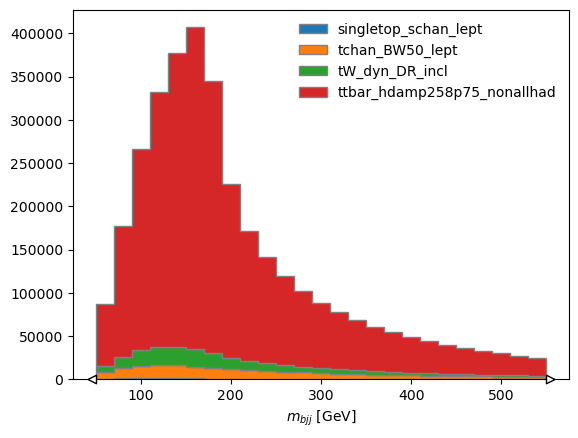

In [13]:
full_histogram_hist_mtop = sum([v for v in out.values()])

artists = full_histogram_hist_mtop.stack("process").plot(
    stack=True, histtype="fill", linewidth=1,edgecolor="grey"
)

ax = artists[0].stairs.axes
fig = ax.get_figure()

ax.legend(frameon=False)